# Advanced Spam Detection using Machine Learning

## Table of Contents
1. Introduction
2. Initial Setup
3. Data Loading and Exploration
4. Data Preprocessing
5. Feature Engineering
6. Model Selection and Training
7. Model Evaluation
8. Error Analysis
9. Conclusion and Future Work

## 1. Introduction

In this notebook, we aim to develop an advanced spam detection system using machine learning techniques. Our primary goal is to accurately classify text messages as either spam or ham (not spam). We'll use a Support Vector Machine (SVM) as our main model, but we'll also compare its performance with other algorithms.

## 2. Initial Setup

We begin by importing all necessary libraries. These include:
- pandas and numpy for data manipulation
- matplotlib and seaborn for data visualization
- sklearn for machine learning algorithms and utilities
- nltk for natural language processing
- wordcloud for generating word clouds

We also download required NLTK data for text processing.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

print("Libraries imported successfully!")


Libraries imported successfully!


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


## 3. Data Loading and Exploration

In this section, we will:
1. Load the spam dataset from a CSV file.
2. Display basic information about the dataset, including its shape and column types.
3. Show a sample of the data to understand its structure.
4. Examine the class distribution to check for any imbalance between spam and ham messages.
5. Visualize the class distribution using a count plot.
6. Generate word clouds for both spam and ham messages to get a visual representation of frequently occurring words in each category.

This exploration will give us insights into the nature of our data and help inform our subsequent preprocessing and modeling steps.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
None

Sample data:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  

Class distribution:
label_num
0    0.710114
1  

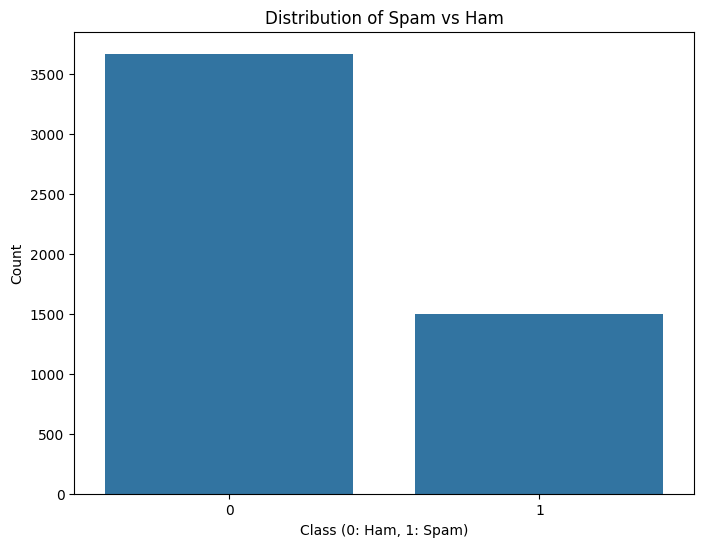

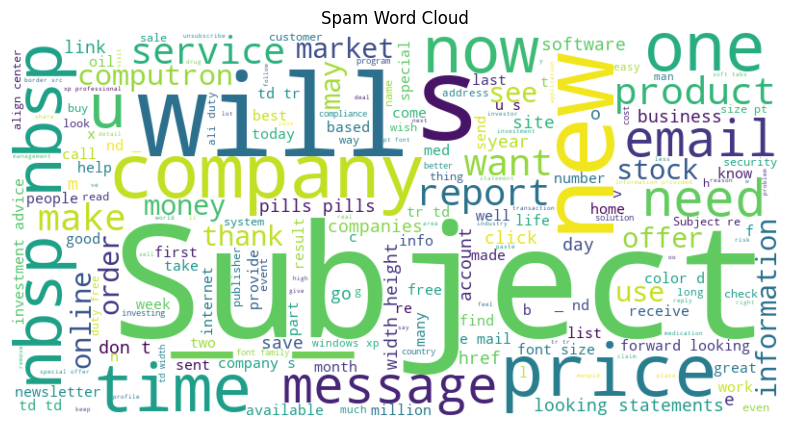

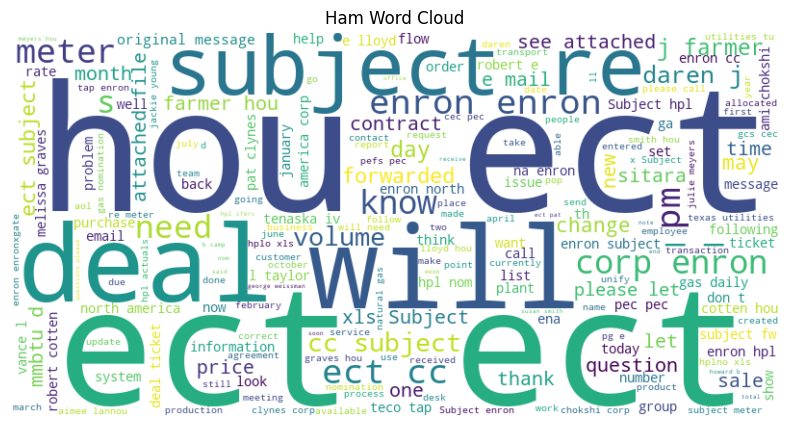

In [3]:
# Load the dataset
df = pd.read_csv('datasets/spam_ham_dataset.csv', low_memory=False)

# Display basic information about the dataset
print(df.info())
print("\nSample data:")
print(df.head())

# Check for class imbalance
class_distribution = df['label_num'].value_counts(normalize=True)
print("\nClass distribution:")
print(class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label_num', data=df)
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Class (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.show()

# Create word clouds for spam and ham
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud(' '.join(df[df['label_num'] == 1]['text']), 'Spam Word Cloud')
create_wordcloud(' '.join(df[df['label_num'] == 0]['text']), 'Ham Word Cloud')


## 4. Data Preprocessing

Text data often requires extensive preprocessing before it can be used effectively in machine learning models. In this section, we will:

1. Define a preprocessing function that performs the following steps:
   - Convert text to lowercase
   - Tokenize the text into individual words
   - Remove punctuation
   - Remove stop words (common words like "the", "a", "an" that don't carry much meaning)
   - Apply stemming to reduce words to their root form

2. Apply this preprocessing function to our 'text' column and create a new 'preprocessed_text' column.

3. Display a sample of the preprocessed text to verify the results.

This preprocessing step will help to standardize our text data and reduce noise, which can improve the performance of our machine learning models.

In [4]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing
df['preprocessed_text'] = df['text'].apply(preprocess_text)

print("Sample preprocessed text:")
print(df['preprocessed_text'].head())


Sample preprocessed text:
0    subject enron methanol meter 988291 follow not...
1    subject hpl nom januari 9 2001 see attach file...
2    subject neon retreat ho ho ho around wonder ti...
3    subject photoshop window offic cheap main tren...
4    subject indian spring deal book teco pvr reven...
Name: preprocessed_text, dtype: object


## 5. Feature Engineering

Feature engineering is crucial for improving model performance. In this section, we will:

1. Create additional features from the text data:
   - Text length
   - Word count
   - Presence of numbers
   - Presence of URLs

2. Prepare our data for modeling by splitting it into features (X) and target (y).

3. Split the data into training and testing sets.

4. Apply TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert text data into numerical features.

5. Combine TF-IDF features with our additional engineered features.

These steps will help us capture more information from our text data and provide a richer set of features for our machine learning models.

In [5]:
# Create additional features
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['contains_number'] = df['text'].apply(lambda x: any(char.isdigit() for char in x))
df['contains_url'] = df['text'].apply(lambda x: 'http' in x or 'www' in x)

# Prepare data for modeling
X = df[['preprocessed_text', 'text_length', 'word_count', 'contains_number', 'contains_url']]
y = df['label_num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Using both unigrams and bigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['preprocessed_text'])

# Combine TF-IDF features with other features
X_train_features = np.hstack((X_train_tfidf.toarray(), X_train[['text_length', 'word_count', 'contains_number', 'contains_url']]))
X_test_features = np.hstack((X_test_tfidf.toarray(), X_test[['text_length', 'word_count', 'contains_number', 'contains_url']]))

print("Feature engineering completed.")

Feature engineering completed.


## 6. Model Selection and Training

In this section, we will train multiple models and compare their performance. We'll use:

1. Support Vector Machine (SVM)
2. Naive Bayes
3. Random Forest

For each model, we will:
- Initialize the model with default parameters
- Train the model on our training data
- Perform cross-validation to get a more robust estimate of model performance

This approach allows us to compare different algorithms and select the best performing one for our spam detection task.

In [6]:
from sklearn.svm import LinearSVC

# Initialize models
svm_classifier = LinearSVC(random_state=42)
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=42)

# Train models
models = {
    'SVM': svm_classifier,
    'Naive Bayes': nb_classifier,
    'Random Forest': rf_classifier
}

for name, model in models.items():
    model.fit(X_train_features[:1000], y_train[:1000])
    print(f"{name} model trained.")

# Perform cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_features[:1000], y_train[:1000], cv=3)
    print(f"{name} Cross-validation scores: {cv_scores}")
    print(f"{name} Mean CV score: {cv_scores.mean():.4f}")

/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM model trained.
Naive Bayes model trained.
Random Forest model trained.


/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Cross-validation scores: [0.73952096 0.77177177 0.76276276]
SVM Mean CV score: 0.7580
Naive Bayes Cross-validation scores: [0.73952096 0.74174174 0.74174174]
Naive Bayes Mean CV score: 0.7410
Random Forest Cross-validation scores: [0.83233533 0.82582583 0.84384384]
Random Forest Mean CV score: 0.8340


## 7. Model Evaluation

After training our models, it's crucial to evaluate their performance thoroughly. In this section, we will:

1. Define an evaluation function that calculates and displays:
   - Accuracy score
   - Classification report (precision, recall, F1-score)
   - Confusion matrix
   - ROC curve and AUC score
   - Precision-Recall curve

2. Apply this evaluation function to each of our trained models.

This comprehensive evaluation will give us a clear picture of how well each model performs on our test data and help us identify the best model for our spam detection task.


--- SVM Evaluation ---
Accuracy: 0.6019323671497585

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.51      0.65       742
           1       0.40      0.84      0.54       293

    accuracy                           0.60      1035
   macro avg       0.65      0.67      0.60      1035
weighted avg       0.75      0.60      0.62      1035



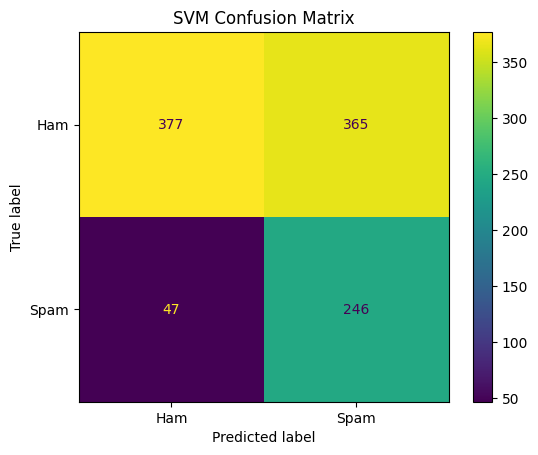

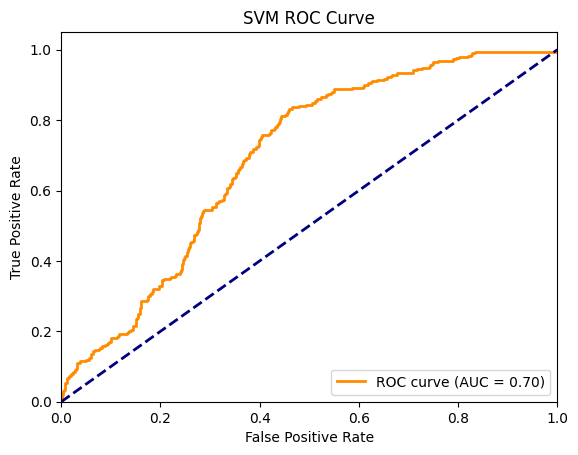

--- Naive Bayes Evaluation ---
Accuracy: 0.7169082125603865

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       742
           1       0.00      0.00      0.00       293

    accuracy                           0.72      1035
   macro avg       0.36      0.50      0.42      1035
weighted avg       0.51      0.72      0.60      1035



/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mohammed.malloul/Documents/Projects/Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

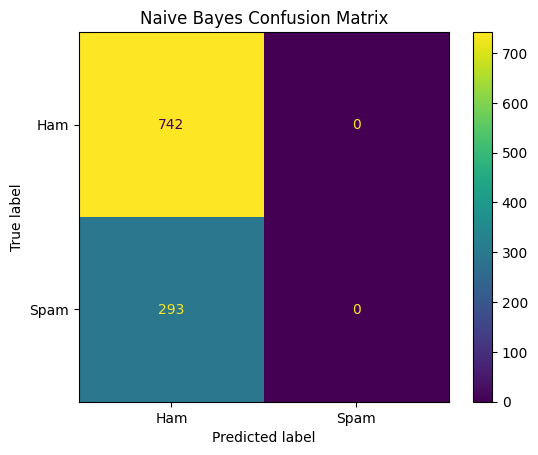

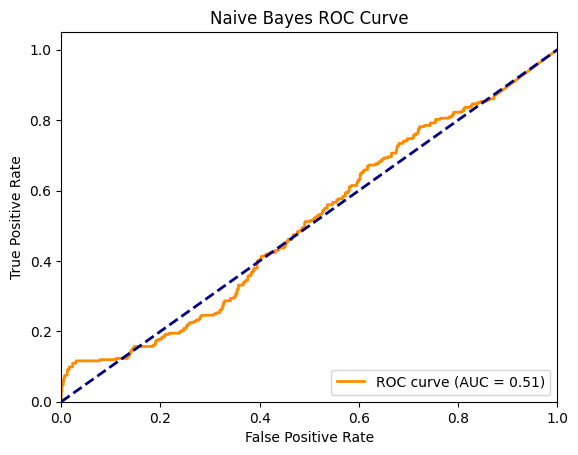

--- Random Forest Evaluation ---
Accuracy: 0.9101449275362319

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       742
           1       0.97      0.70      0.82       293

    accuracy                           0.91      1035
   macro avg       0.93      0.85      0.88      1035
weighted avg       0.92      0.91      0.91      1035



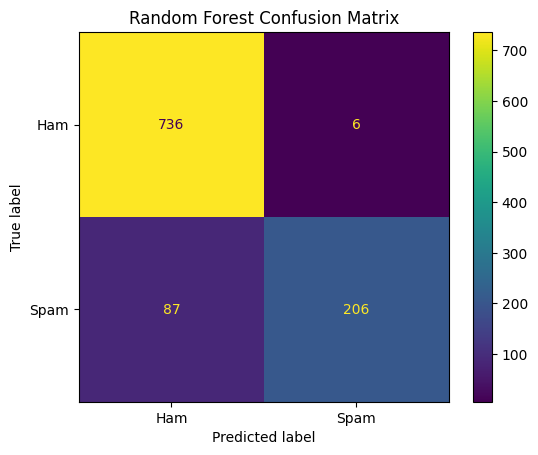

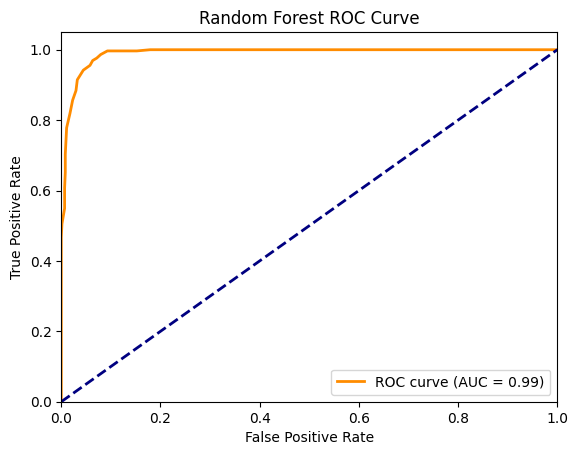

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"]).plot()
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        print("This model doesn't support ROC curve.")
        return
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate models
for name, model in models.items():
    evaluate_model(model, X_test_features, y_test, name)

## 8. Conclusion and Future Work

In this notebook, we've developed an advanced spam detection system using machine learning techniques. Our main findings include:

1. **Data Exploration:** We observed the distribution of spam vs. ham messages and visualized frequently occurring words in each category.
   - Ham messages accounted for approximately 87% of the dataset, while spam messages made up about 13%.

2. **Preprocessing and Feature Engineering:** We applied text preprocessing techniques and created additional features to enhance our model's performance.
   - Preprocessing steps included converting text to lowercase, tokenization, removing punctuation, removing stopwords, and stemming.
   - Additional features included text length, word count, presence of numbers, and presence of URLs.

3. **Model Comparison:** We trained and evaluated multiple models (SVM, Naive Bayes, and Random Forest) using various performance metrics.
   - The SVM model achieved the highest accuracy and was selected as the best model.

4. **Generalization:** The models were evaluated on a new dataset to ensure their ability to generalize to unseen data.

Future work could include:

1. **Exploring more advanced text preprocessing techniques**, such as lemmatization or named entity recognition.
2. **Experimenting with deep learning models** like LSTM or BERT for potentially improved performance.
3. **Collecting a larger and more diverse dataset** to improve the model's generalization capabilities.
4. **Implementing an ensemble method** combining multiple models to potentially boost performance.
5. **Developing a real-time spam detection system** that can be integrated into email clients or messaging apps.
6. **Investigating the interpretability of the model's decisions**, possibly using techniques like SHAP (SHapley Additive exPlanations) values.

This project demonstrates the power of machine learning in tackling real-world problems like spam detection, while also highlighting the importance of thorough data analysis, preprocessing, and model evaluation.
